In [1]:
##################################
#                                #
# regression.ipynb               #
# Created 2022-07-10             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [9]:
data = pd.read_excel('AMR_imputation_6.xlsx').drop('#',axis='columns')

In [10]:
# Only keep data prior to a change in the micro lab reporting system
data2019 = data[data['Episode'] <= 7217]

# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data2019[data2019[abx]=='no_data'].shape[0] / data2019.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))

Missingness
Penicillin        2.42%
Amoxiclav        35.25%
Ampicillin        1.01%
Cloxacillin       6.52%
Piptaz            1.28%
Cefazolin         1.44%
Ceftriaxone       0.54%
Ceftazidime       0.87%
Ertapenem         1.58%
Meropenem         0.50%
Ciprofloxacin     1.31%
Levofloxacin     16.67%
Moxifloxacin      4.67%
Daptomycin        1.85%
Vancomycin        1.85%
Linezolid         1.85%
Amikacin          2.35%
Tobramycin        0.64%
Gentamicin        0.60%
Clindamycin       4.37%
Doxycycline      80.85%
Erythromycin     55.31%
TMPSMX            0.57%


## Preprocessing

In [11]:
# Change missing data to be resistant
data2019[output_antibiotics] = data2019[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data2019 = data2019.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Create categorical variable columns
# Encode ages as integer variables
ages = {'<40':1, '40-45':2, '45-50':3, '50-55':4, '55-60':5, '60-65':6, 
        '65-70':7, '70-75':8, '75-80':9, '80-85':10, '85-90':11, '>90':12}
data2019['Age'] = data2019['AgeCat'].map(ages)

# Encode sex as male=0, female=1
sexes = {'M':0,'F':1}
data2019['SexCat'] = data2019['Sex'].map(sexes)
data2019

# Change medical vs. surgical admitting service from 1/2 to 0/1
data['Medical(1) Surgical (2) Admitting Service'] = data['Medical(1) Surgical (2) Admitting Service'].replace({1:0,2:1})
data = data.rename({'Medical(1) Surgical (2) Admitting Service':'MedVsSurgAdmission'},axis=1)

# Encode culture type
culture_types = {'BLDC':1,'URCR':2,'BCPOS':1,'CSFCS':3,'URCC':2,
                 'FLDC':3,'BONEC':3,'BXTC' :3,'EARC':3,'FLDBC':3,
                 'FUNC':3,'GMISC':3,'DIALC':3,'INCC':3,'LRESC':3,
                 'ORCU':3,'STCS' :3,'TDRNC':3,'VTIPC':3}
data2019['CultureSource'] = data2019['culture_test_cd'].map(culture_types)

# Create new categories of "prior non-[antibiotic class]"
data2019['PriorNonCephalosporin'] = data2019[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
data2019['PriorNonCarbapenem'] = data2019[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
data2019['PriorNonPenicillin'] = data2019[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonFQ'] = data2019[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonAMG'] = data2019[['PriorFQ','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonOtherAbx'] = data2019[['PriorFQ','PriorAMG','PriorCephalosporin','PriorPenicillin','PriorCarbapenem']].any(axis='columns')

# Converts True/False into 1/0
data2019['PriorNonCephalosporin'] = data2019['PriorNonCephalosporin'].apply(int)
data2019['PriorNonCarbapenem']    = data2019['PriorNonCarbapenem'].apply(int)
data2019['PriorNonPenicillin']    = data2019['PriorNonPenicillin'].apply(int)
data2019['PriorNonFQ']            = data2019['PriorNonFQ'].apply(int)
data2019['PriorNonAMG']           = data2019['PriorNonAMG'].apply(int)
data2019['PriorNonOtherAbx']      = data2019['PriorNonOtherAbx'].apply(int)

data2019 = data2019.drop(['MRSA12months','VRE12months','ESBL12months','MRSA7days','VRE7days','ESBL7days',
                          'NumberOfBacteremiasLastYear','ClincalMRSA','ClinicalVRE'],axis=1,errors='ignore')
data2019

,Anonymous_ID,Episode,AgeCat,Sex,YearOfAdmission,Medical(1) Surgical (2) Admitting Service,ClinicalESBL,RecentHospitalization,ICUExposure,PriorAMG,...,TMPSMX_PGNO_imp,Age,SexCat,CultureSource,PriorNonCephalosporin,PriorNonCarbapenem,PriorNonPenicillin,PriorNonFQ,PriorNonAMG,PriorNonOtherAbx
0,1,1,85-90,M,2008,1,0,0,0,0,...,NaN,11,0,2,1,1,0,1,1,1
1,1,2,85-90,M,2008,1,0,0,0,0,...,0.00,11,0,2,1,1,1,1,1,1
2,2,9,>90,M,2011,1,0,0,0,0,...,NaN,12,0,2,0,0,0,0,0,0
3,3,15,>90,M,2012,1,0,0,0,0,...,NaN,12,0,2,0,0,0,0,0,0
4,4,25,45-50,F,2013,1,0,0,0,0,...,NaN,3,1,2,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2313,7212,60-65,M,2019,1,0,0,0,0,...,NaN,6,0,2,0,0,0,0,0,0
2972,2314,7215,75-80,M,2019,1,0,1,0,0,...,NaN,9,0,1,0,0,0,0,0,0
2973,2314,7215,75-80,M,2019,1,0,1,0,0,...,NaN,9,0,2,0,0,0,0,0,0
2974,2314,7216,75-80,M,2019,1,0,1,1,0,...,1.00,9,0,1,1,1,1,1,1,1


In [12]:
# List of antibiotics to run regression on
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin','Tobramycin','TMPSMX']
antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ','Tobramycin':'AMG',
                      'TMPSMX':'OtherAbx'}

# Regression Function


Regression model for Cefazolin

Logistic Regression Coefficients
PriorGNresistance                           1.4913
ClinicalESBL                                1.0637
PriorCephalosporin                          0.5475
ICUExposure                                 0.3697
Medical(1) Surgical (2) Admitting Service   0.3325
PriorNonCephalosporin                       0.1168
Age                                        -0.0567
RecentHospitalization                      -0.1624
SexCat                                     -0.4152

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.07
                     median:  0.68
                     mean:    0.65
                     max:     0.80
                     
Resistant isolates   min:     0.04
                     median:  0.51
                     mean:    0.47
                     max:     0.79
                     

Bin minimum   S count  R count  S percentage
       0.00         1       18          0.05
       0.

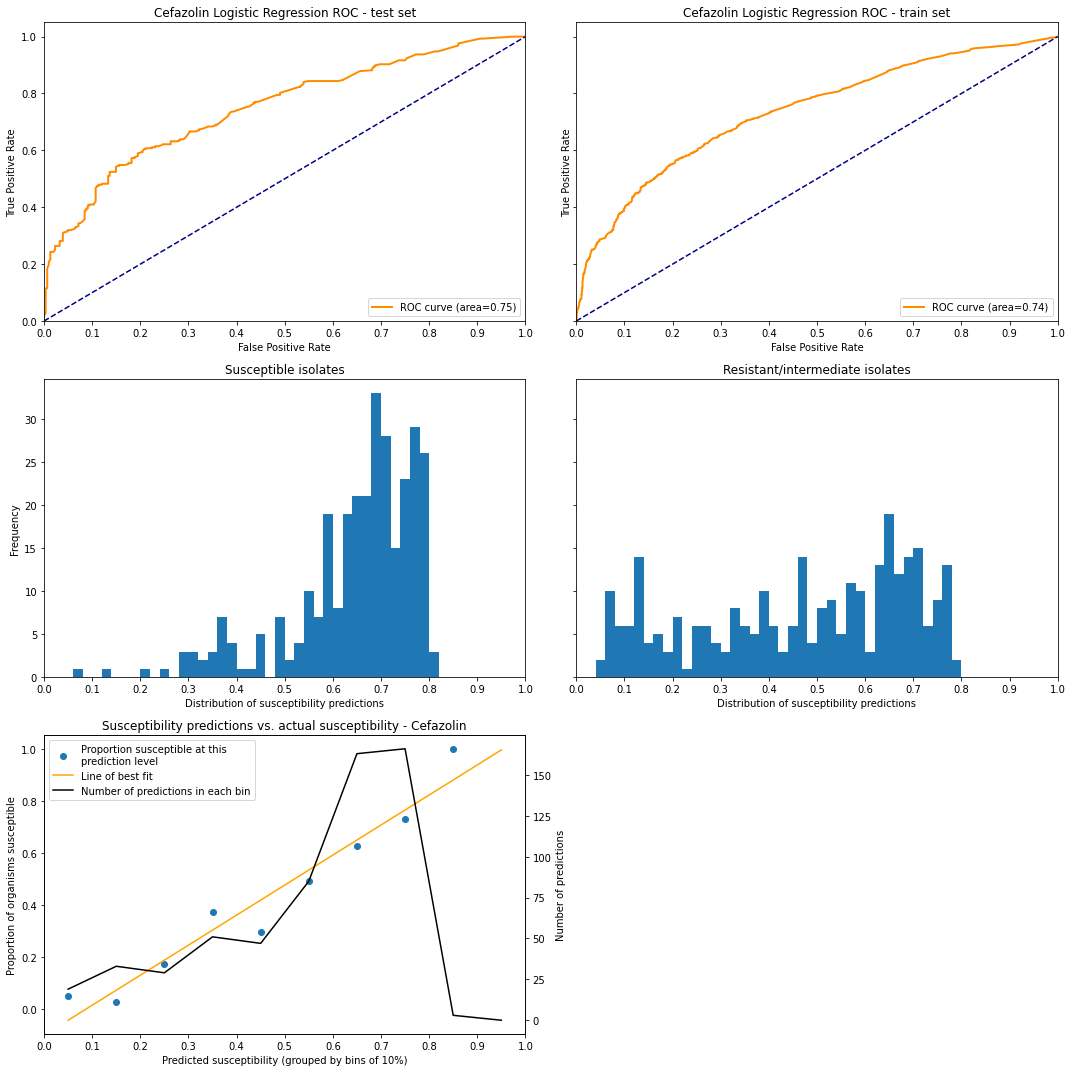


Regression model for Ceftriaxone

Logistic Regression Coefficients
PriorGNresistance                           1.7600
ClinicalESBL                                1.0818
PriorCephalosporin                          0.6196
PriorNonCephalosporin                       0.2058
ICUExposure                                 0.1688
Medical(1) Surgical (2) Admitting Service   0.1441
Age                                        -0.0626
RecentHospitalization                      -0.1444
SexCat                                     -0.1553

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.09
                     median:  0.80
                     mean:    0.76
                     max:     0.87
                     
Resistant isolates   min:     0.06
                     median:  0.65
                     mean:    0.57
                     max:     0.86
                     

Bin minimum   S count  R count  S percentage
       0.00         1        6          0.14
       

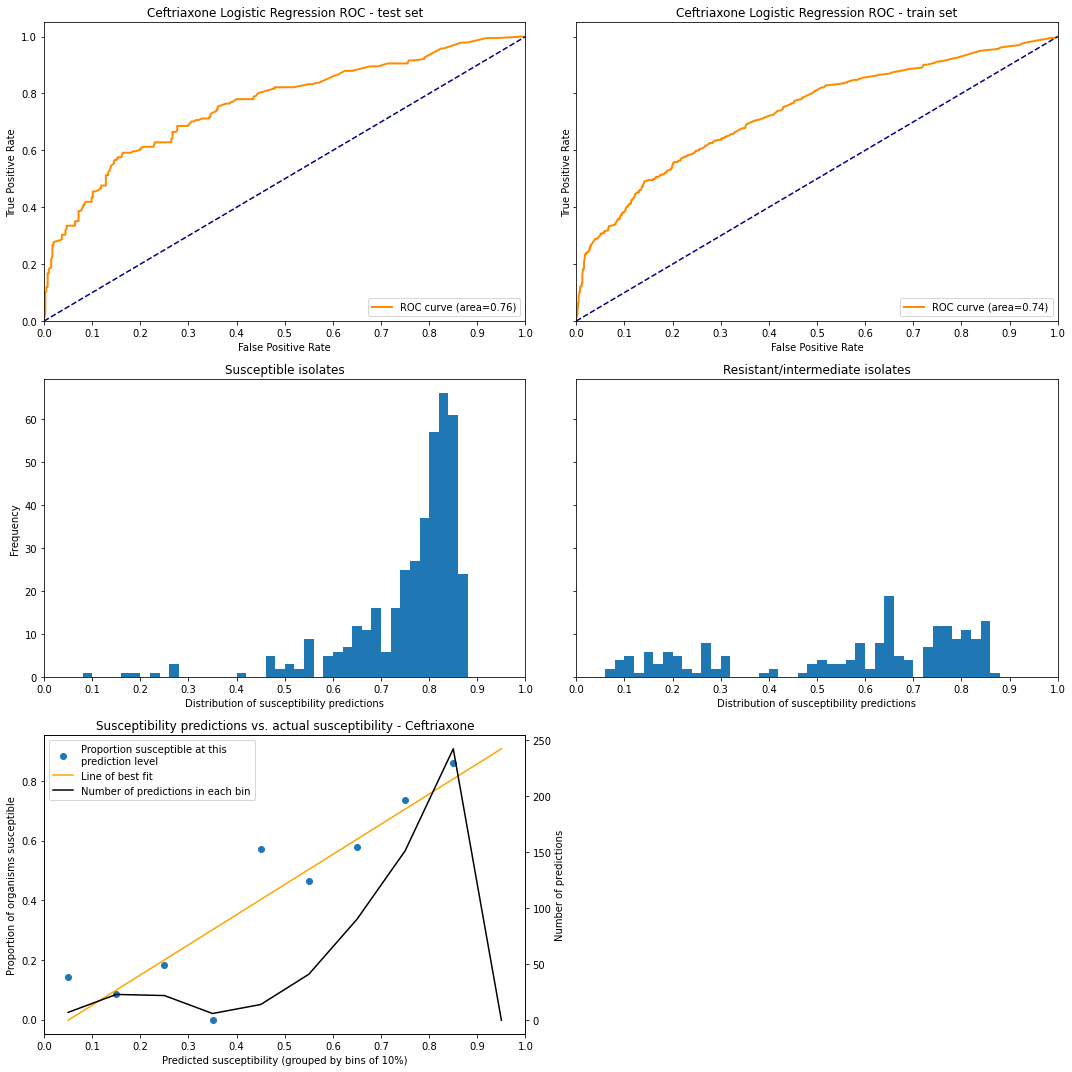


Regression model for Ceftazidime

Logistic Regression Coefficients
ClinicalESBL                                1.4195
PriorGNresistance                           1.3862
PriorCephalosporin                          0.3441
PriorNonCephalosporin                       0.2684
Medical(1) Surgical (2) Admitting Service   0.1716
SexCat                                      0.1194
ICUExposure                                 0.0924
RecentHospitalization                      -0.0246
Age                                        -0.0450

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.18
                     median:  0.87
                     mean:    0.84
                     max:     0.91
                     
Resistant isolates   min:     0.15
                     median:  0.80
                     mean:    0.71
                     max:     0.91
                     

Bin minimum   S count  R count  S percentage
       0.00         0        0           nan
       

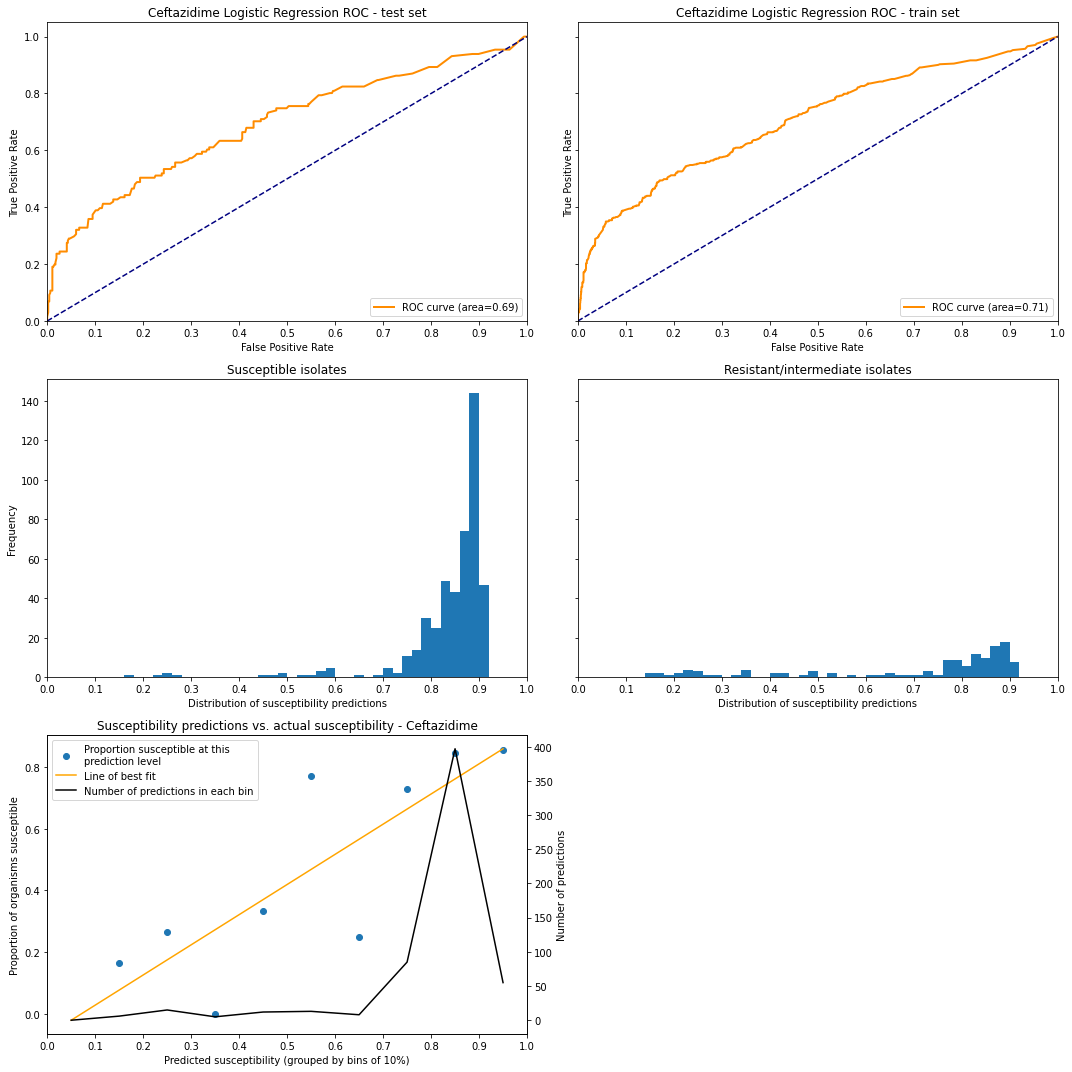


Regression model for Piptaz

Logistic Regression Coefficients
PriorGNresistance                           1.3453
ClinicalESBL                                1.1768
PriorNonPenicillin                          0.5292
PriorPenicillin                             0.2564
Medical(1) Surgical (2) Admitting Service   0.1987
SexCat                                      0.0143
ICUExposure                                 0.0050
Age                                        -0.0480
RecentHospitalization                      -0.1558

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.17
                     median:  0.84
                     mean:    0.81
                     max:     0.90
                     
Resistant isolates   min:     0.13
                     median:  0.74
                     mean:    0.67
                     max:     0.88
                     

Bin minimum   S count  R count  S percentage
       0.00         0        0           nan
       0.10 

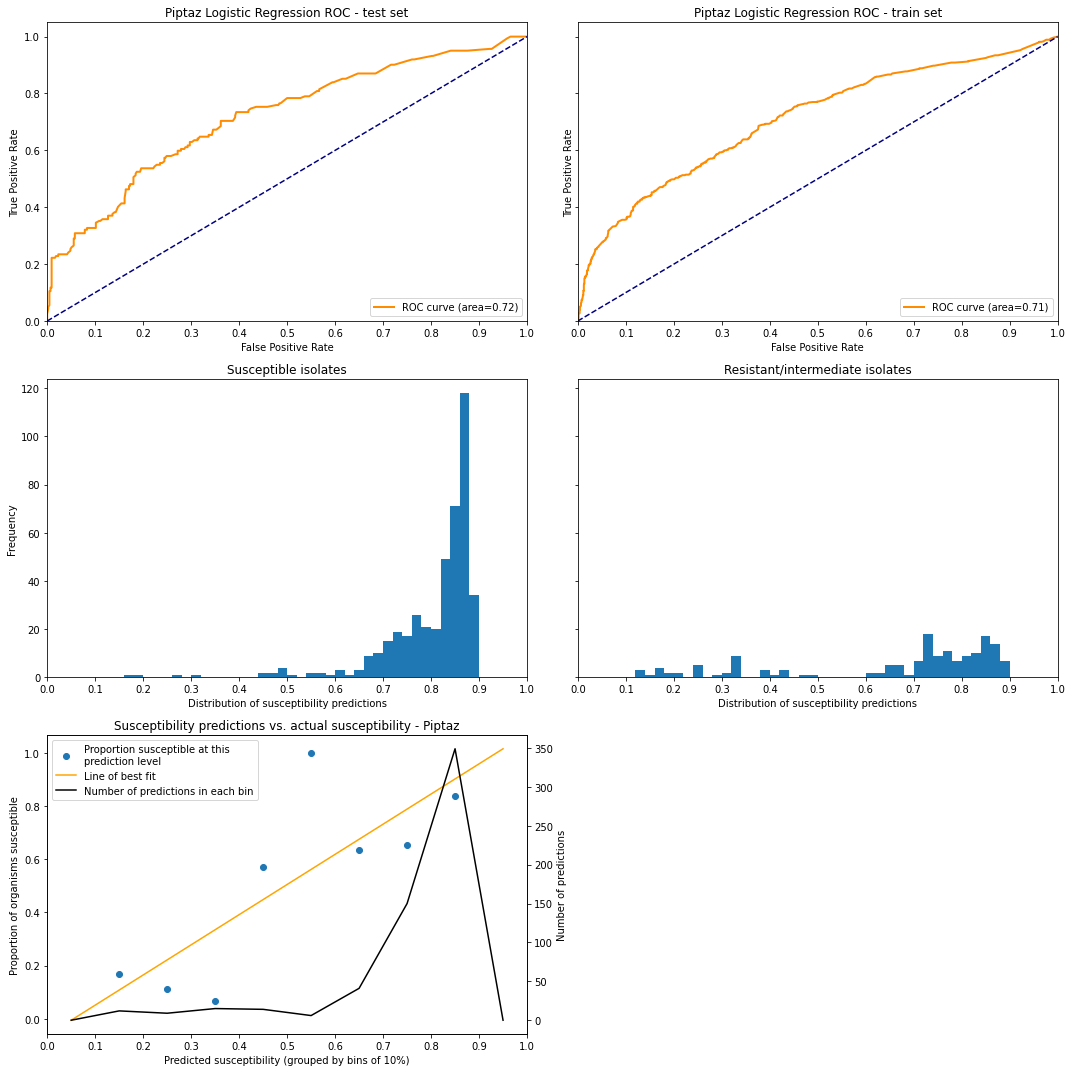


Regression model for Meropenem

Logistic Regression Coefficients
PriorGNresistance                           2.0068
PriorCarbapenem                             1.5947
ICUExposure                                 0.2932
ClinicalESBL                                0.2086
PriorNonCarbapenem                          0.0290
Age                                        -0.1486
SexCat                                     -0.2510
Medical(1) Surgical (2) Admitting Service  -0.4073
RecentHospitalization                      -0.5318

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.39
                     median:  0.98
                     mean:    0.96
                     max:     1.00
                     
Resistant isolates   min:     0.24
                     median:  0.88
                     mean:    0.78
                     max:     0.99
                     

Bin minimum   S count  R count  S percentage
       0.00         0        0           nan
       0.

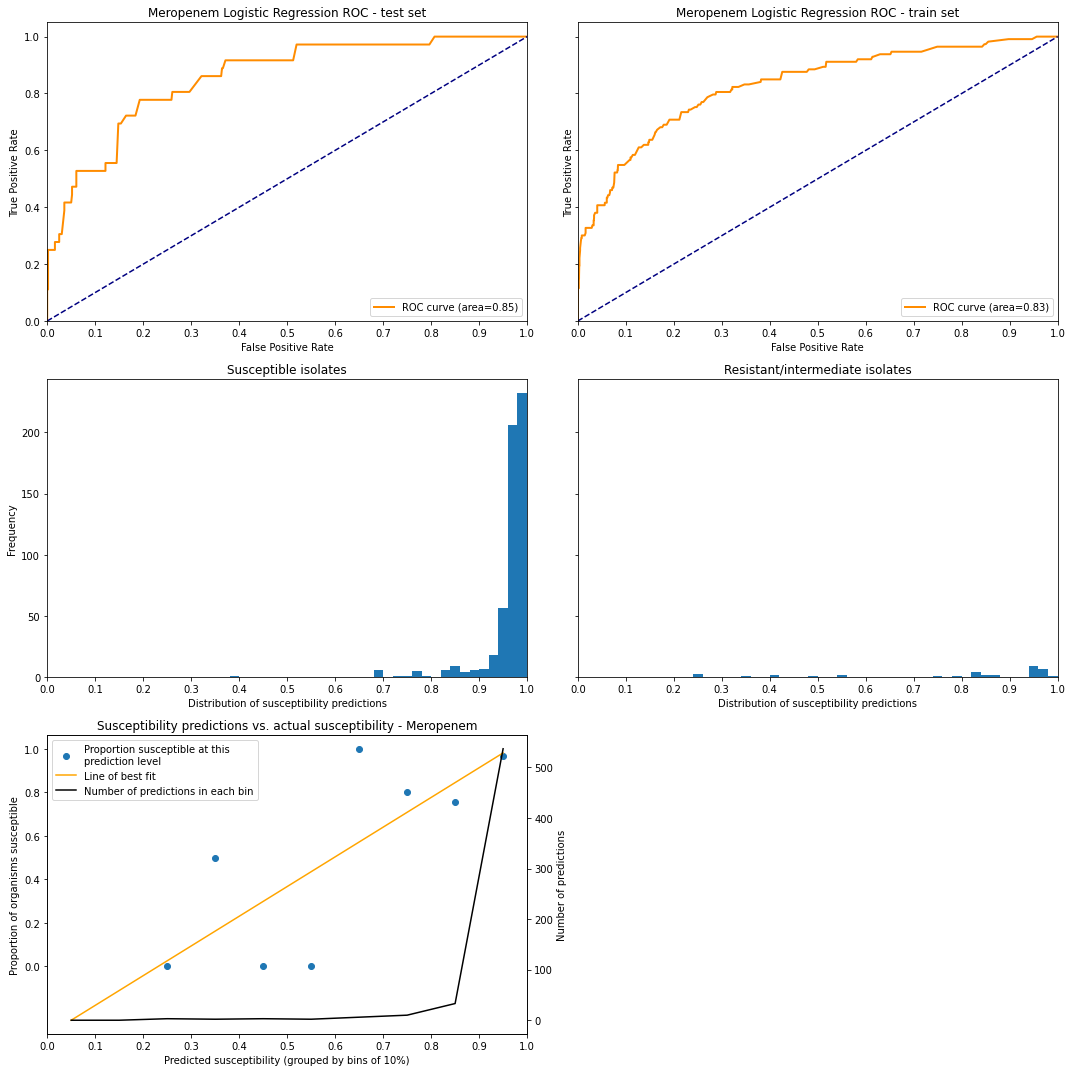


Regression model for Ciprofloxacin

Logistic Regression Coefficients
PriorGNresistance                           1.7148
ClinicalESBL                                1.0200
PriorFQ                                     0.9953
Age                                        -0.0207
RecentHospitalization                      -0.0301
Medical(1) Surgical (2) Admitting Service  -0.1309
SexCat                                     -0.3276
PriorNonFQ                                 -0.3847
ICUExposure                                -0.4283

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.26
                     median:  0.83
                     mean:    0.82
                     max:     0.92
                     
Resistant isolates   min:     0.08
                     median:  0.77
                     mean:    0.67
                     max:     0.91
                     

Bin minimum   S count  R count  S percentage
       0.00         0        2          0.00
     

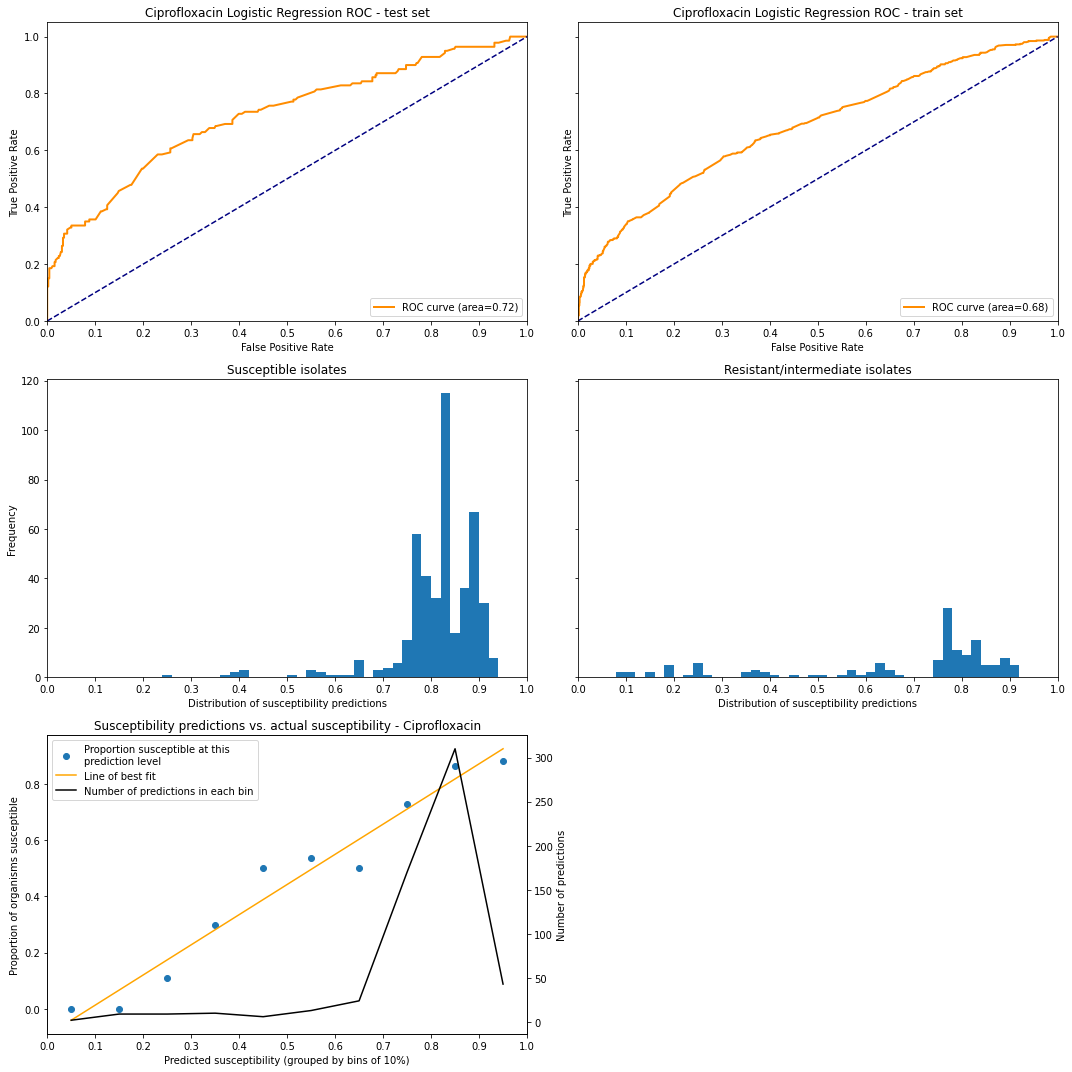


Regression model for Tobramycin

Logistic Regression Coefficients
PriorGNresistance                           2.1677
ClinicalESBL                                0.5203
PriorAMG                                    0.4746
RecentHospitalization                       0.1278
Age                                        -0.0066
PriorNonAMG                                -0.0121
ICUExposure                                -0.1091
Medical(1) Surgical (2) Admitting Service  -0.2459
SexCat                                     -0.4762

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.37
                     median:  0.91
                     mean:    0.90
                     max:     0.95
                     
Resistant isolates   min:     0.35
                     median:  0.90
                     mean:    0.85
                     max:     0.95
                     

Bin minimum   S count  R count  S percentage
       0.00         0        0           nan
       0

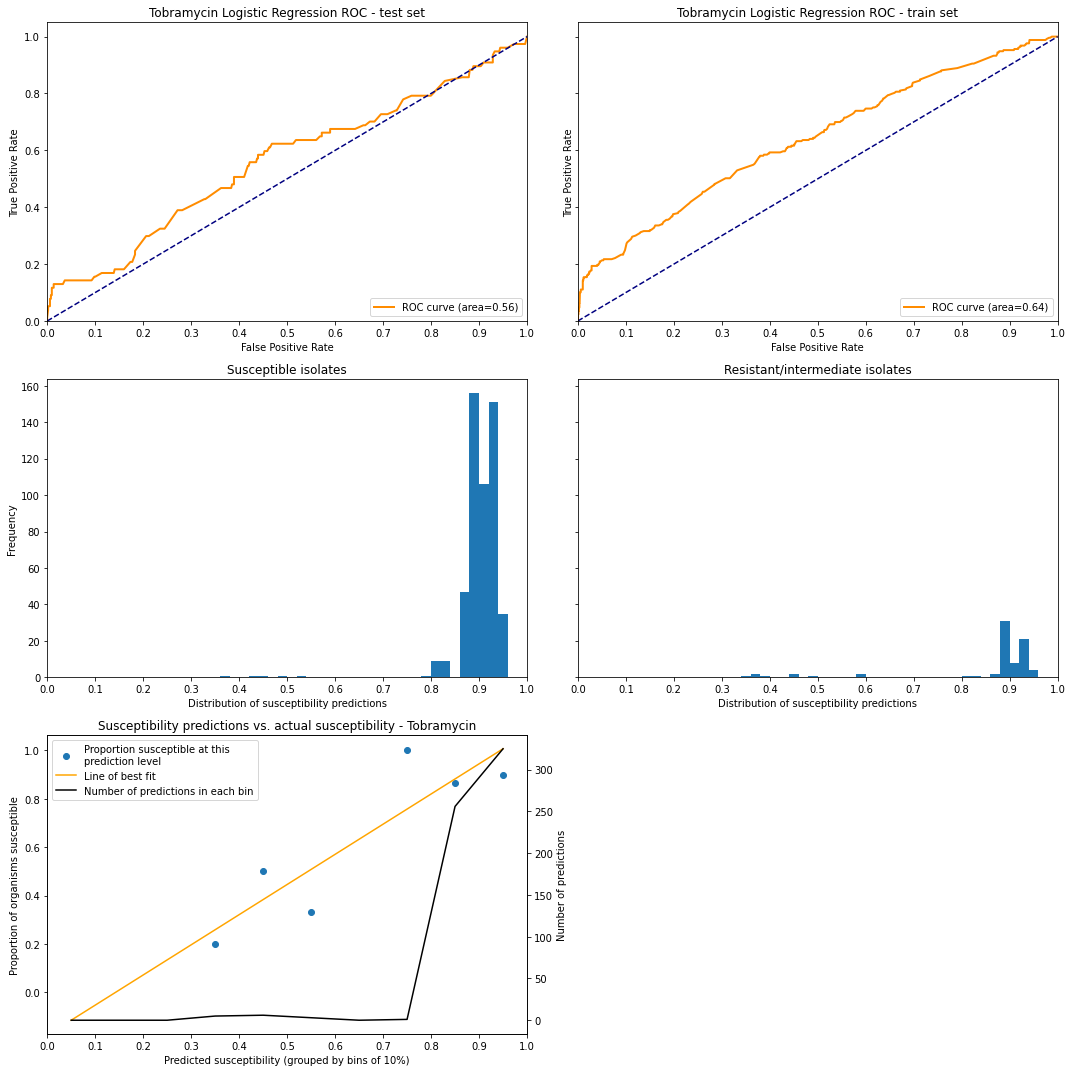


Regression model for TMPSMX

Logistic Regression Coefficients
PriorGNresistance                           2.0359
ClinicalESBL                                0.5627
PriorOtherAbx                               0.2117
PriorNonOtherAbx                            0.1933
Medical(1) Surgical (2) Admitting Service   0.1912
Age                                        -0.0621
SexCat                                     -0.0862
RecentHospitalization                      -0.1042
ICUExposure                                -0.2440

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.16
                     median:  0.75
                     mean:    0.73
                     max:     0.83
                     
Resistant isolates   min:     0.08
                     median:  0.70
                     mean:    0.59
                     max:     0.81
                     

Bin minimum   S count  R count  S percentage
       0.00         0        4          0.00
       0.10 

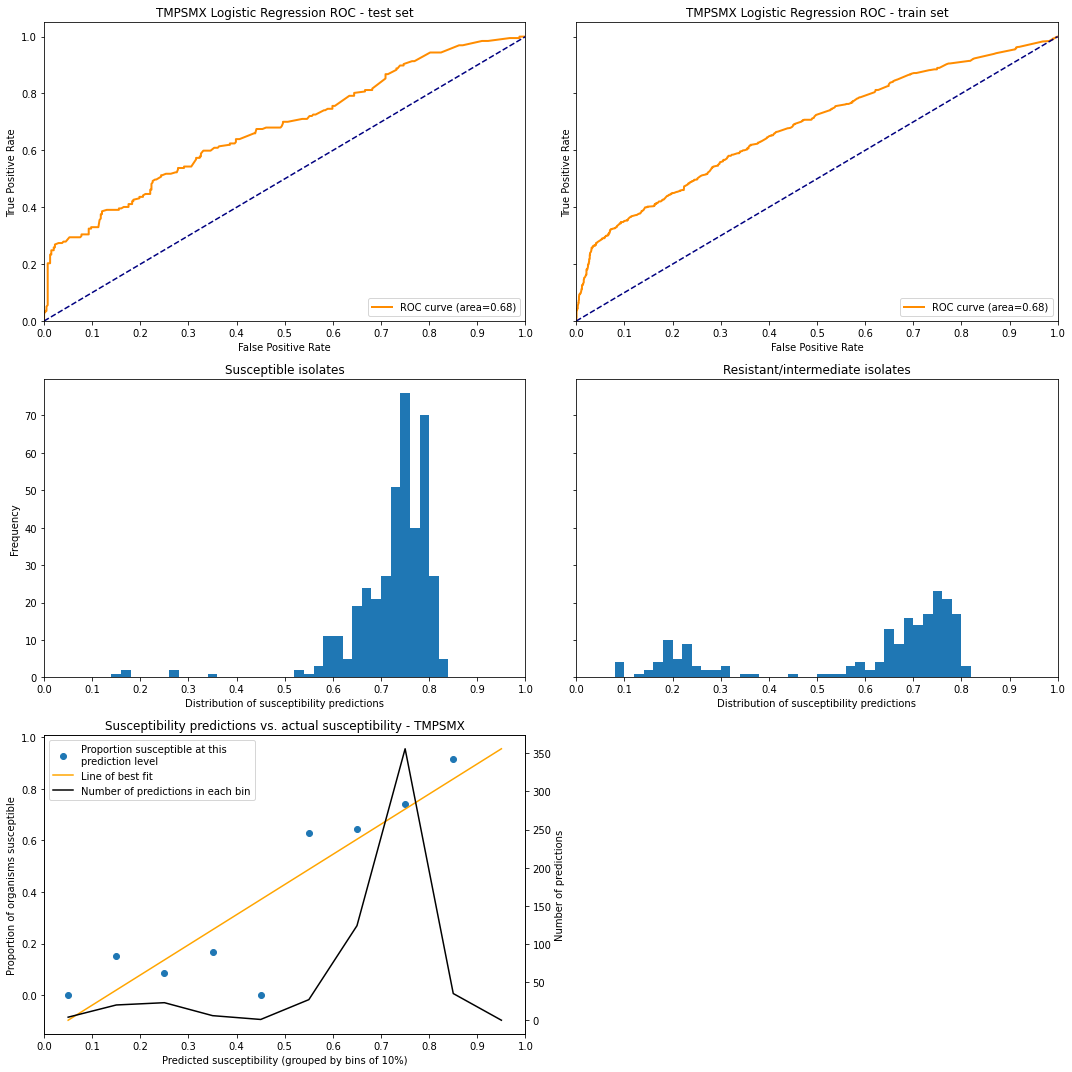

In [15]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous susceptible gram negative organism
        1 if previous resistant gram negative organism
        1 if previous gram negative organism without susceptibility data
    '''
    
    if priorGNOrg=='no_data': return 0
    elif prior_susceptibility=='no_data': 
        return 1
    else: return prior_susceptibility


def antibiotic_susceptibility_regression(antibiotic):
    
    print('\nRegression model for {}\n'.format(antibiotic))
    
    # Add a column for previous susceptibility to the particular antibiotic
    data2019['PriorGNresistance'] = data2019.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)
    
    regression_inputs = ['Age','SexCat','Medical(1) Surgical (2) Admitting Service','ClinicalESBL',
                         'RecentHospitalization','ICUExposure','PriorGNresistance',
                         'Prior'+antibiotic_classes[antibiotic],'PriorNon'+antibiotic_classes[antibiotic]]
        
    # Divide data into temporal 80-20 train-test sets
    train_set, test_set= np.split(data2019, [int(.8 *len(data2019))])

    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']
        
    reg = linear_model.LogisticRegression()
    reg.fit(X_train,Y_train)

    # Coefficients sorted by size
    print('Logistic Regression Coefficients')
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<42} {: .4f}'.format(i[1],i[0]))
    
    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))
    # If one wanted to use the decision function rather than the predicted probability
    # predict_results = sorted((zip(reg.decision_function(X_test),Y_test)),key=lambda x:(x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

    # Print descriptive statistics
    print('\nProbability of susceptibility: prediction outputs')

    print('''Susceptible isolates min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(susceptible_isolates),
                                np.median(susceptible_isolates),
                                np.mean(susceptible_isolates),
                                max(susceptible_isolates)))    
    print('''Resistant isolates   min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(resistant_isolates),
                                np.median(resistant_isolates),
                                np.mean(resistant_isolates),
                                max(resistant_isolates)))  

            
    # Generate plots
        
    # Calculate and plot ROC based on test set
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

    fig, ax = plt.subplots(nrows=3,ncols=2, 
                           sharex='col',sharey = "row", 
                           figsize=(15,15))

    ax[0,0].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,0].set_xlim([0.0, 1.0])
    ax[0,0].set_ylim([0.0, 1.05])
    ax[0,0].xaxis.set_tick_params(labelbottom=True)    
    ax[0,0].set_xlabel("False Positive Rate")
    ax[0,0].set_ylabel("True Positive Rate")
    ax[0,0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
    ax[0,0].legend(loc="lower right")

    # Calculate and plot ROC based on test set
    fpr, tpr, thresholds = metrics.roc_curve(Y_train,reg.decision_function(X_train))
    AUC = metrics.roc_auc_score(Y_train,reg.decision_function(X_train))

    ax[0,1].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,1].set_xlim([0.0, 1.0])
    ax[0,1].set_ylim([0.0, 1.05])
    ax[0,1].set_xticks(np.arange(0,1.1,0.1))
    ax[0,1].xaxis.set_tick_params(labelbottom=True)
    ax[0,1].set_xlabel("False Positive Rate")
    ax[0,1].set_ylabel("True Positive Rate")
    ax[0,1].set_title("{} Logistic Regression ROC - train set".format(antibiotic))
    ax[0,1].legend(loc="lower right")            
        
    # Plot a histogram of predictions on susceptible and resistant isolates    
    bins = 50

    ax[1,0].hist(susceptible_isolates,
             bins=bins,range=(0,1))    
    ax[1,0].set_title('Susceptible isolates')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].set_xlabel('Distribution of susceptibility predictions')
    ax[1,0].xaxis.set_tick_params(labelbottom=True)    

    ax[1,1].hist(resistant_isolates,
             bins=bins,range=(0,1))
    ax[1,1].set_title('Resistant/intermediate isolates')
    ax[1,1].set_xlabel('Distribution of susceptibility predictions')
    ax[1,1].xaxis.set_tick_params(labelbottom=True)    
    
    
    # Divide the predictions into 10 bins, and count the number of predictions for resistant and susceptible in each bin
    print('\n{:<12}  {}  {}  {}'.format('Bin minimum','S count','R count','S percentage'))
    
    # First, obtain raw prediction or decision function values to create bins
    probability_list = [x[0] for x in predict_results]

    # Create bins of 0.1 each
    hist_edges = np.arange(0,1.05,0.1)
    
    # For later plotting
    bin_medians = np.arange(0.05,1.05,0.1)
    bin_susceptibilities = []
    bin_counts = [0]*len(bin_medians)
    
    # Then, loop over bins
    for i in range(len(hist_edges)-1):
        
        # Count the number of susceptible and resistant predictions in each bin
        susceptible_number = 0
        resistant_number = 0        
        for j in predict_results:
            if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
                if j[1] == 0: susceptible_number +=1
                if j[1] == 1: resistant_number   +=1
                bin_counts[i] += 1
                
        # Print and plot observations for each bin
        try:
            percent_susceptible = susceptible_number/(resistant_number+susceptible_number)
            print('{:> 11.2f}{:>10}{:>9}{:>14.2f}'.format(hist_edges[i],
                                                          susceptible_number,
                                                          resistant_number,
                                                          percent_susceptible))            
            bin_susceptibilities.append(percent_susceptible)
            
        except ZeroDivisionError:
            print('{:> 11.2f}{:>10}{:>9}{:>14}'.format(hist_edges[i],susceptible_number,resistant_number,np.nan))
            bin_susceptibilities.append(np.nan)
    
    print()

    # Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
    ax2a = ax[2,0]
    ax2b = ax[2,0].twinx()
    
    ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
    ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
    ax2a.set_xticks(np.arange(0,1.1,0.1))
    ax2a.set_ylabel('Proportion of organisms susceptible')

    # Create a bar chart
    ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
    ax2b.set_ylabel('Number of predictions')
    
    # Create a scatter plot
    bin_susceptibilities = np.array(bin_susceptibilities)
    ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
    ax2a.set_yticks(np.arange(0,1.1,0.2))    
        
    # Create a line of best fit
    non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
    m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
    ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    
    
    # Create a legend
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines + lines2, labels + labels2, loc='upper left')
    
    # Delete the bottom right graph and plot the others
    ax[2,1].axis('off')
    plt.tight_layout()
    plt.show()
    
    
for antibiotic in antibiotic_list:
    antibiotic_susceptibility_regression(antibiotic)

In [14]:
# Mean predicted susceptibility of each antibiotic
print('Mean predicted susceptibility of each analyzed antibiotic\n')
print('{:<15} {:<7}'.format('Antibiotic','Prob S'))

for antibiotic in antibiotic_list:

    data2019['PriorGNresistance'] = data2019.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)

    regression_inputs = ['Age','SexCat','Medical(1) Surgical (2) Admitting Service','ClinicalESBL',
                         'RecentHospitalization','ICUExposure','PriorGNresistance',
                         'Prior'+antibiotic_classes[antibiotic],'PriorNon'+antibiotic_classes[antibiotic]]

    # Divide data into 80-20 train-test sets
    train_set, test_set= np.split(data2019, [int(.8 *len(data2019))])

    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']

    reg = linear_model.LogisticRegression()
    reg.fit(X_train,Y_train)
    
    print('{:<15} {:>6.2f}'.format(antibiotic, np.mean(reg.predict_proba(X_test)[:,0])))

Mean predicted susceptibility of each analyzed antibiotic

Antibiotic      Prob S 
Cefazolin         0.56
Ceftriaxone       0.70
Ceftazidime       0.81
Piptaz            0.77
Meropenem         0.95
Ciprofloxacin     0.78
Tobramycin        0.90
TMPSMX            0.68


Logistic Regression Coefficients
PriorGNresistance                           5.3860
PriorNonPenicillin                          0.5820
Medical(1) Surgical (2) Admitting Service   0.0302
PriorAMG                                    0.0233
ClinicalESBL                               -0.0304
RecentHospitalization                      -0.0370
Age                                        -0.0518
PriorNonAMG                                -0.2620
PriorPenicillin                            -0.2857
ICUExposure                                -0.2882
SexCat                                     -0.4241

Probability prediction outputs
Susceptible isolates min:     0.02
                     median:  0.04
                     mean:    0.05
                     max:     0.10
                     
Resistant isolates   min:     0.03
                     median:  0.05
                     mean:    0.29
                     max:     0.94
                     

Bin minimum   S count  R count  S percentage
    

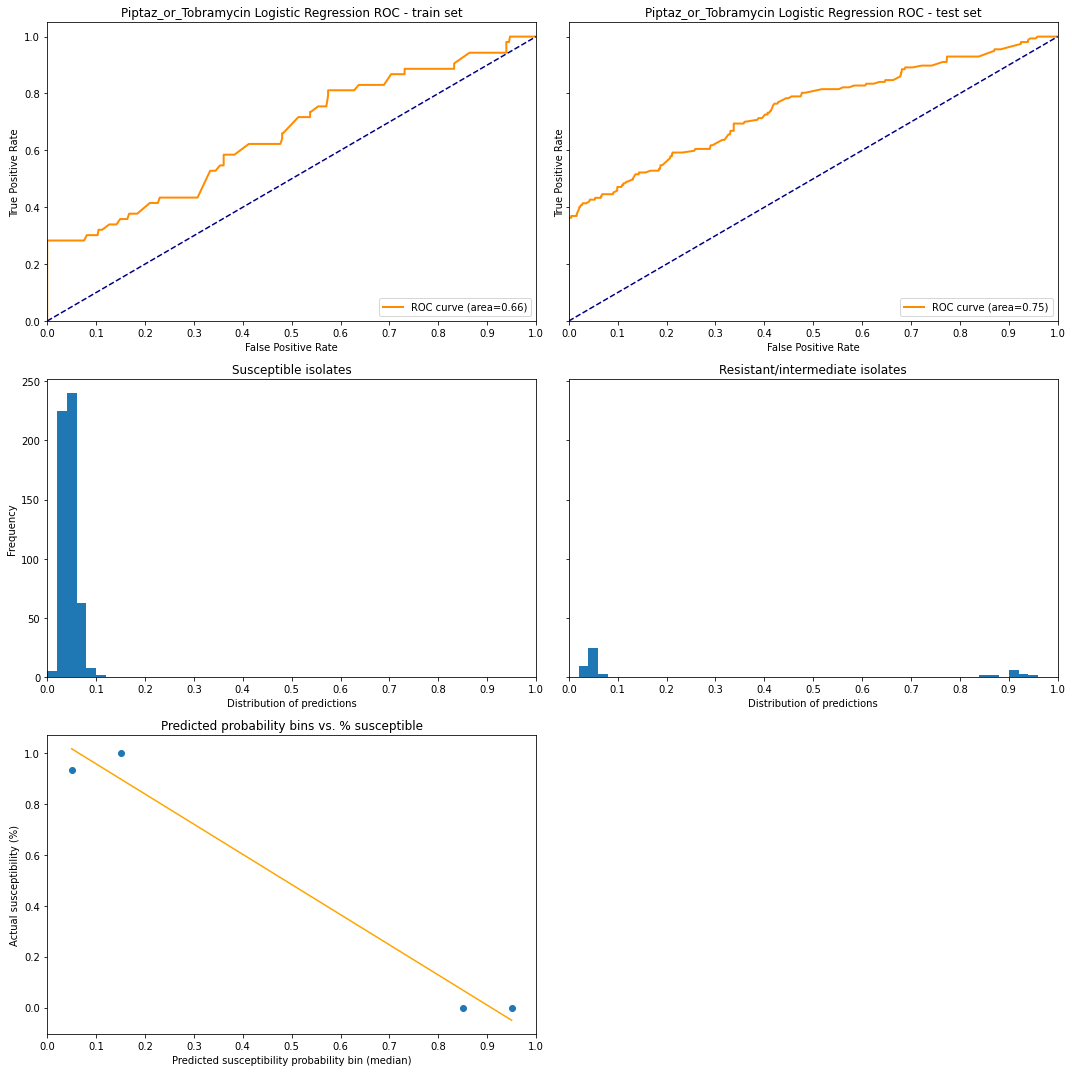

In [8]:
# Combination piperacilliln-tazobactam and tobramycin

antibiotic = 'Piptaz_or_Tobramycin'

# Create a new column based on a multiplication (would only be 1 if both are 1, otherwise 0)
data2019[antibiotic] = (data2019['Piptaz_FINAL_imp'])*(data2019['Tobramycin_FINAL_imp'])

# Add a column for previous susceptibility to pip-tazo and tobramycin
data2019['PriorGNresistance'] = data2019.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic]), axis=1)

regression_inputs = ['Age','SexCat','Medical(1) Surgical (2) Admitting Service','ClinicalESBL',
                     'RecentHospitalization','ICUExposure',
                     'PriorGNresistance','PriorPenicillin','PriorAMG','PriorNonPenicillin','PriorNonAMG']

# Divide data into temporal 80-20 train-test sets
train_set, test_set= np.split(data2019, [int(.8 *len(data2019))])

X_train = train_set[regression_inputs]
X_test  = test_set [regression_inputs]
Y_train = train_set[antibiotic]
Y_test  = test_set [antibiotic]

reg = linear_model.LogisticRegression()
reg.fit(X_train,Y_train)

# Coefficients sorted by size
print('Logistic Regression Coefficients')
for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
    print('{:<42} {: .4f}'.format(i[1],i[0]))

# Zip together prediction values and actual test values
# Then sort by susceptible strains first, followed by prediction values
predict_results = sorted((zip(reg.predict_proba(X_test)[:,1],Y_test)),key=lambda x:(x[1],x[0]))
# If one wanted to use the decision function rather than the predicted probability
# predict_results = sorted((zip(reg.decision_function(X_test),Y_test)),key=lambda x:(x[1],x[0]))

# Separate out predictions on susceptible and resistant isolates
susceptible_isolates = []
resistant_isolates   = []
for i in predict_results:
    if i[1]==1:
        resistant_isolates.append(i[0])
    else: susceptible_isolates.append(i[0])

# Print descriptive statistics
print('\nProbability prediction outputs')

print('''Susceptible isolates min:    {:> .2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(susceptible_isolates),
                            np.median(susceptible_isolates),
                            np.mean(susceptible_isolates),
                            max(susceptible_isolates)))    
print('''Resistant isolates   min:    {:> .2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(resistant_isolates),
                            np.median(resistant_isolates),
                            np.mean(resistant_isolates),
                            max(resistant_isolates)))  


# Generate plots

# Calculate and plot ROC based on training set
fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

fig, ax = plt.subplots(nrows=3,ncols=2, 
                       sharex='col',sharey = "row", 
                       figsize=(15,15))

ax[0,0].plot(fpr, tpr, color="darkorange", lw=2,
    label="ROC curve (area={:.2})".format(AUC))

ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
ax[0,0].set_xlim([0.0, 1.0])
ax[0,0].set_ylim([0.0, 1.05])
ax[0,0].xaxis.set_tick_params(labelbottom=True)    
ax[0,0].set_xlabel("False Positive Rate")
ax[0,0].set_ylabel("True Positive Rate")
ax[0,0].set_title("{} Logistic Regression ROC - train set".format(antibiotic))
ax[0,0].legend(loc="lower right")

# Calculate and plot ROC based on test set
fpr, tpr, thresholds = metrics.roc_curve(Y_train,reg.decision_function(X_train))
AUC = metrics.roc_auc_score(Y_train,reg.decision_function(X_train))

ax[0,1].plot(fpr, tpr, color="darkorange", lw=2,
    label="ROC curve (area={:.2})".format(AUC))

ax[0,1].plot([0, 1], [0, 1], color="navy", linestyle="--")
ax[0,1].set_xlim([0.0, 1.0])
ax[0,1].set_ylim([0.0, 1.05])
ax[0,1].set_xticks(np.arange(0,1.1,0.1))
ax[0,1].xaxis.set_tick_params(labelbottom=True)
ax[0,1].set_xlabel("False Positive Rate")
ax[0,1].set_ylabel("True Positive Rate")
ax[0,1].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
ax[0,1].legend(loc="lower right")            

# Plot a histogram of predictions on susceptible and resistant isolates    
bins = 50

ax[1,0].hist(susceptible_isolates,
         bins=bins,range=(0,1))
ax[1,0].set_title('Susceptible isolates')
ax[1,0].set_ylabel('Frequency')
ax[1,0].set_xlabel('Distribution of predictions')
ax[1,0].xaxis.set_tick_params(labelbottom=True)    

ax[1,1].hist(resistant_isolates,
         bins=bins,range=(0,1))
ax[1,1].set_title('Resistant/intermediate isolates')
ax[1,1].set_xlabel('Distribution of predictions')
ax[1,1].xaxis.set_tick_params(labelbottom=True)    

# Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
ax[2,0].set_title('Predicted probability bins vs. % susceptible')
ax[2,0].set_xlabel('Predicted susceptibility probability bin (median)')
ax[2,0].set_xticks(np.arange(0,1.1,0.1))
ax[2,0].set_ylabel('Actual susceptibility (%)')
ax[2,0].set_yticks(np.arange(0,1.1,0.2))    
# ax[2,0].legend(loc="upper right")            

# Divide the predictions into 10 bins, and count the number of predictions for resistant and susceptible in each bin
print('\n{:<12}  {}  {}  {}'.format('Bin minimum','S count','R count','S percentage'))

# First, obtain raw prediction or decision function values to create bins
probability_list = [x[0] for x in predict_results]

# Create bins of 0.1 each
hist_edges = np.arange(0,1.05,0.1)

# For later plotting
bin_medians = np.arange(0.05,1.05,0.1)
bin_susceptibilities = []

# Then, loop over bins
for i in range(len(hist_edges)-1):

    # Count the number of susceptible and resistant predictions in each bin
    susceptible_number = 0
    resistant_number = 0        
    for j in predict_results:
        if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
            if j[1] == 0: susceptible_number +=1
            if j[1] == 1: resistant_number  +=1

    # Print and plot observations for each bin
    try:
        percent_susceptible = susceptible_number/(resistant_number+susceptible_number)
        print('{:> 11.2f}{:>10}{:>9}{:>14.2f}'.format(hist_edges[i],
                                                      susceptible_number,
                                                      resistant_number,
                                                      percent_susceptible))            
        bin_susceptibilities.append(percent_susceptible)

    except ZeroDivisionError:
        print('{:> 11.2f}{:>10}{:>9}{:>14}'.format(hist_edges[i],susceptible_number,resistant_number,np.nan))
        bin_susceptibilities.append(np.nan)

print()

# Create a scatter plot
bin_susceptibilities = np.array(bin_susceptibilities)
ax[2,0].scatter(bin_medians,bin_susceptibilities,color='C0')

# Create a line of best fit
non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
ax[2,0].plot(bin_medians,m*bin_medians+b,c='orange')    

# Delete the bottom right graph and plot the others
ax[2,1].axis('off')
plt.tight_layout()
plt.show()